# Workflows and Agents

This guide reviews common architectures for agentic systems. In describing these systems, it can be useful to make a distinction between "workflows" and "agents". Anthropic released an excellent [blog post](https://www.anthropic.com/research/building-effective-agents) on building effective agents that highlights both "agents" and "workflows":

> "Agent" can be defined in several ways. Some customers define agents as fully autonomous systems that operate independently over extended periods, using various tools to accomplish complex tasks. Others use the term to describe more prescriptive implementations that follow predefined "workflows". At Anthropic, we categorize all these variations as agentic systems.

It explains the primary difference between agents and workflows: 

> Workflows are systems where LLMs and tools are orchestrated through predefined code paths.
> Agents, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

Here is a simple way to visualize these differences:

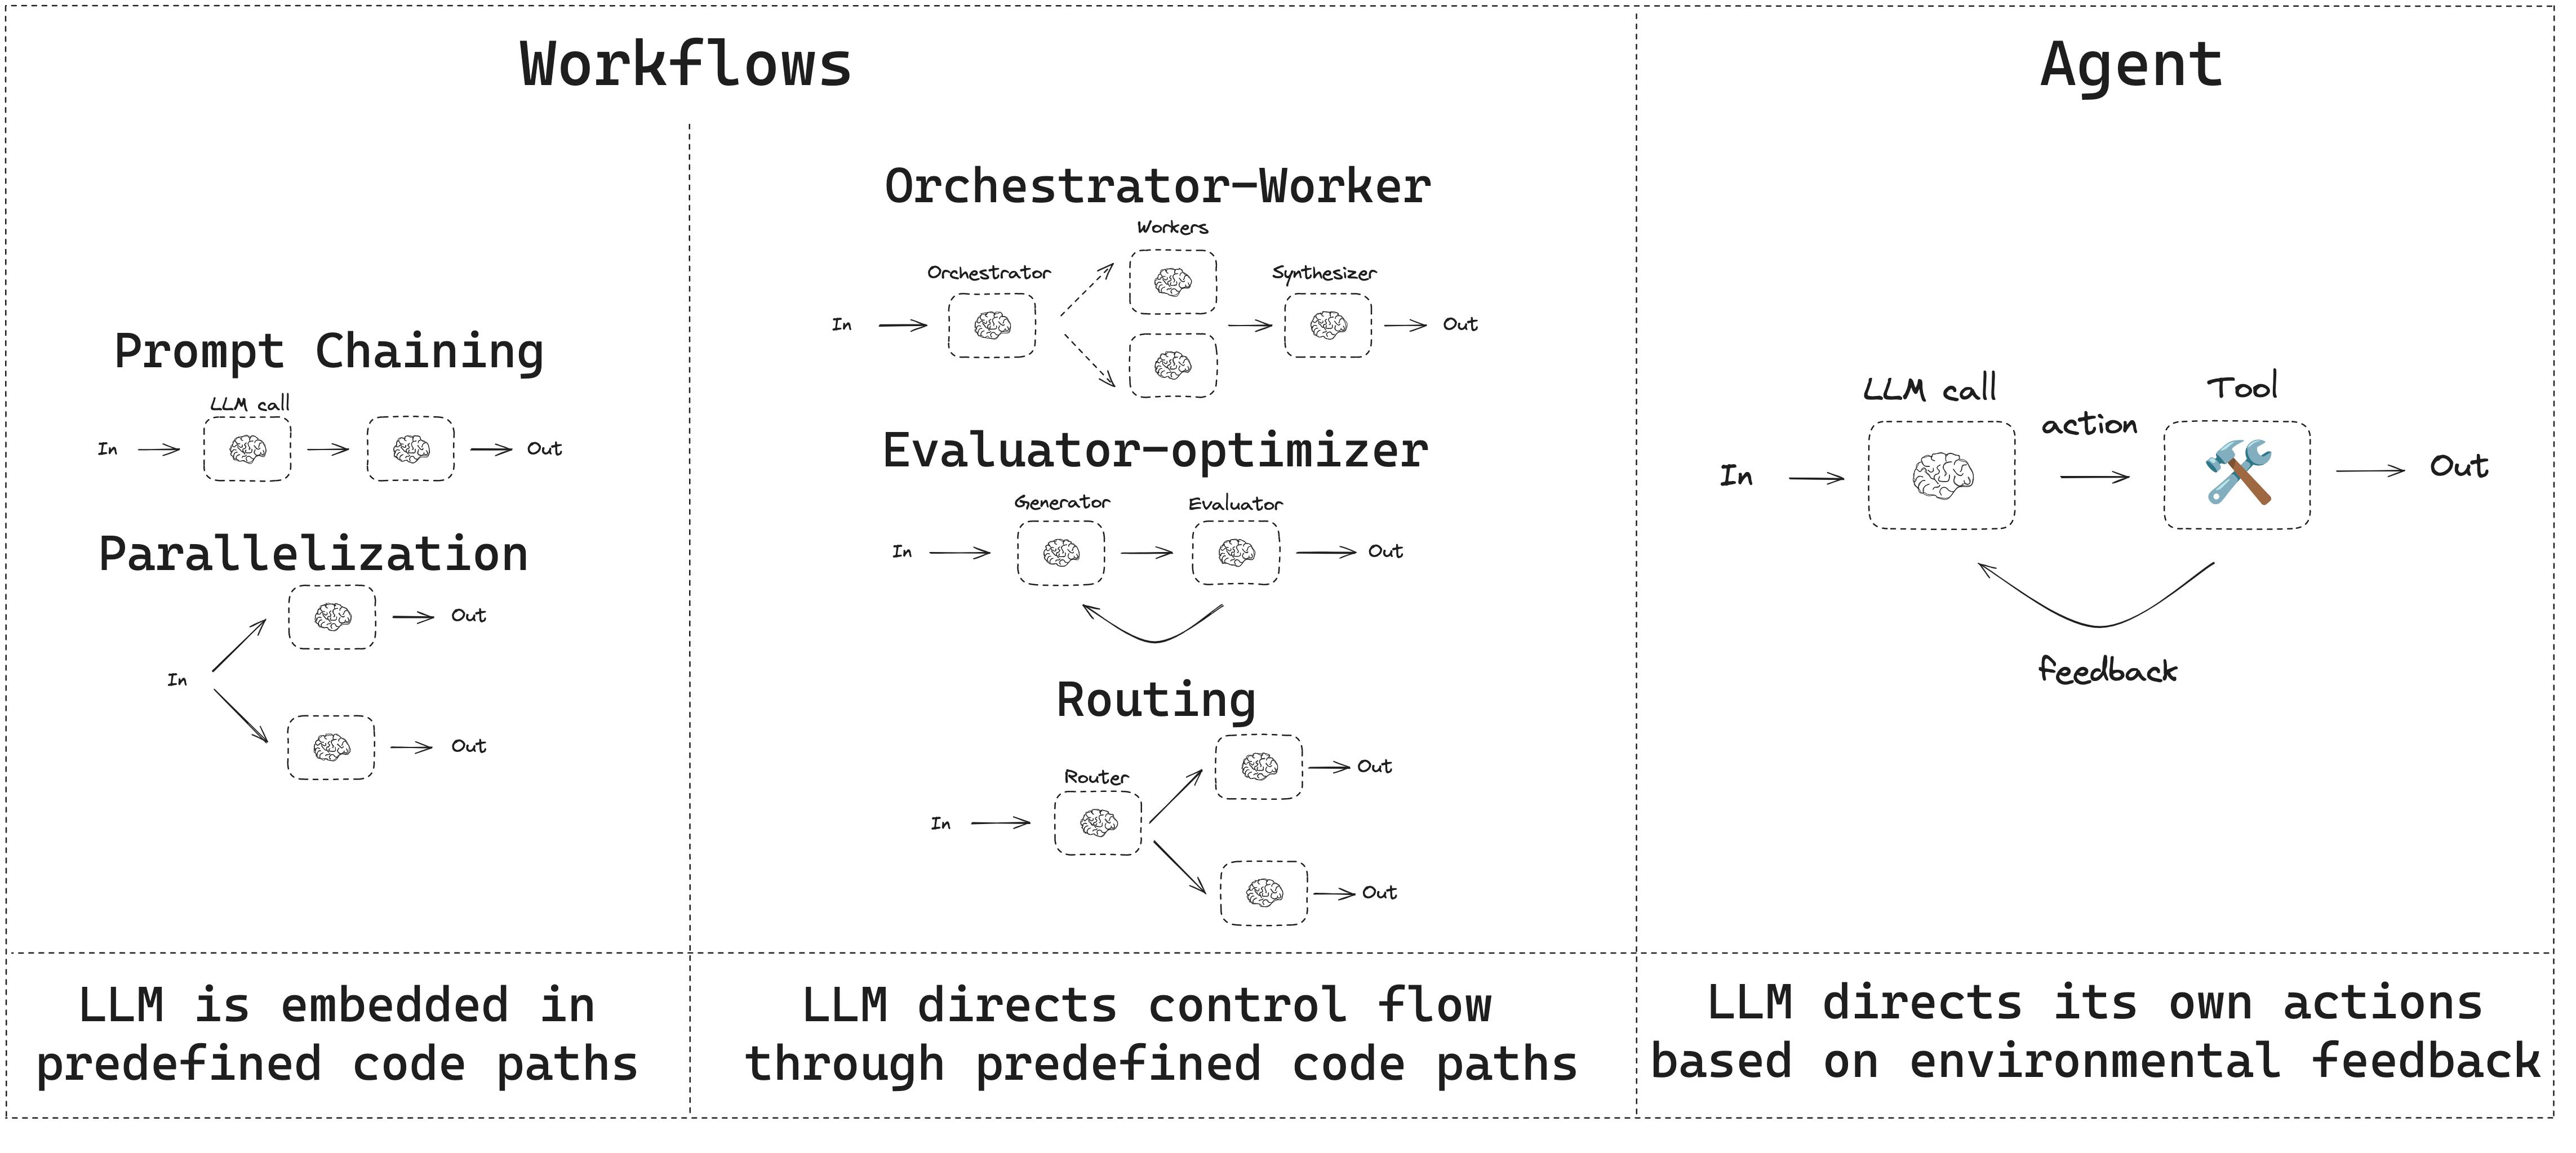

## Why use a framework like LangGraph?

The blog also discusses when to consider agent frameworks. For any framework, it is important to understand the costs (or overhead) of using it versus the benefits. The blog points out that frameworks *can* add abstraction, often to promote speed or ease of use. But, this can come with costs, such as difficulty debugging or incorrect assumptions:

> (Frameworks) often create extra layers of abstraction that can obscure the underlying prompts and responses, making them harder to debug.

Our documentation [outlines](https://langchain-ai.github.io/langgraph/concepts/high_level/) the the benefits of using LangGraph: LangGraph doesn't abstract prompts or architecture. It provides supporting infrastructure for any workflow / agent, including persistence, streaming, and support for deployment.

## Building Blocks: The Augmented LLM 

LLM have [augmentations](https://www.anthropic.com/research/building-effective-agents) that support building workflows and agents. 

These include [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/) and [tool calling](https://python.langchain.com/docs/concepts/tool_calling/), as shown in the blog:

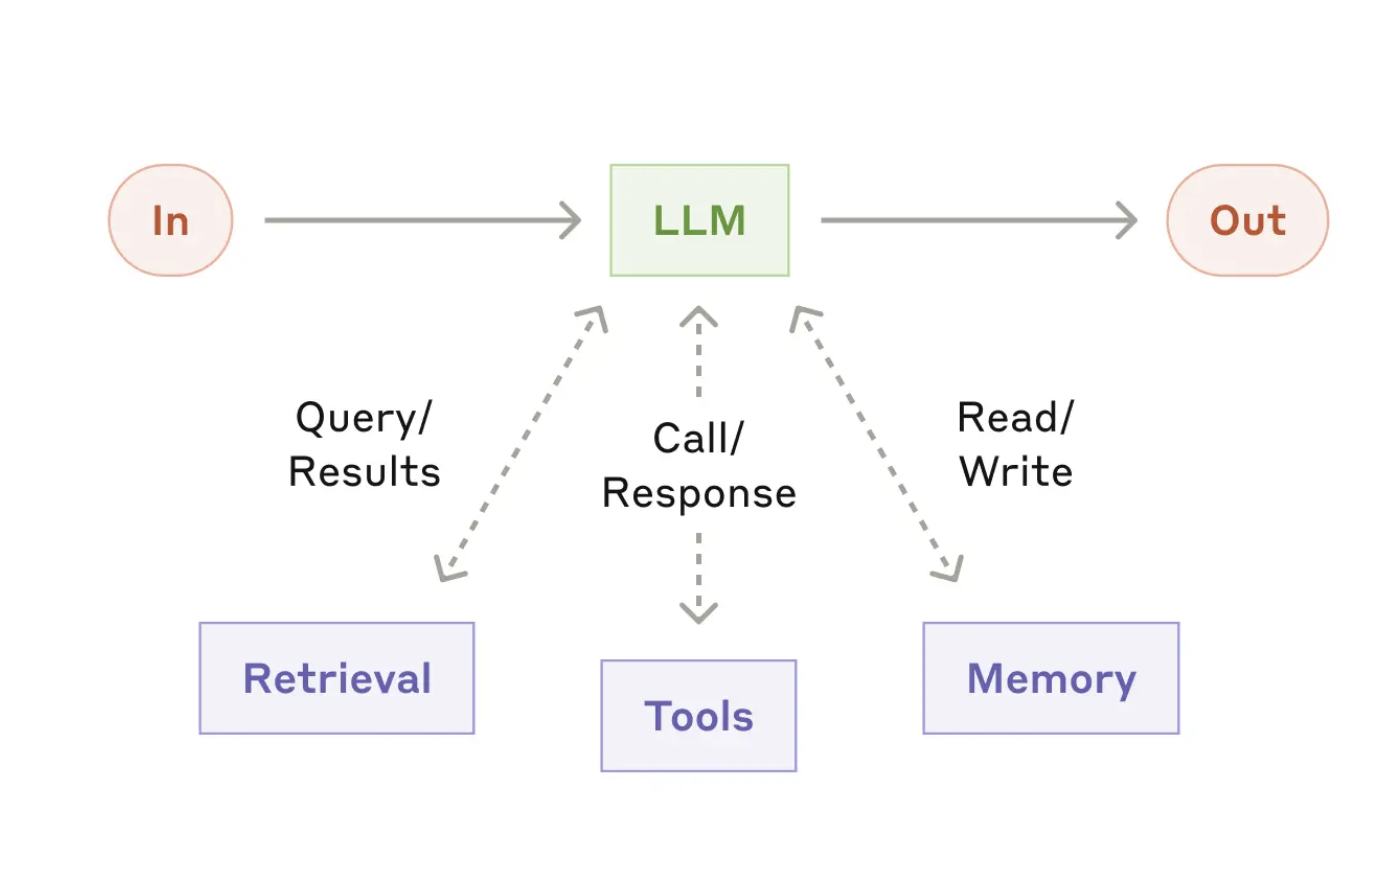

For this tutorial, you can use [any chat model](https://python.langchain.com/docs/integrations/chat/) that supports structured outputs and tool calling. Below, we show the process of installing the packages, setting API keys, and testing structured outputs / tool calling for both OpenAI and Anthropic. 

In [1]:
%pip install langchain_core langchain-openai langchain-anthropic langgraph

In [2]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


In [3]:
# LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [4]:
from pydantic import BaseModel, Field


# Schema for structured output
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

Calcium CT score relation to high cholesterol
Understanding the link between Calcium CT scores and cholesterol levels can help in assessing cardiovascular risks.


In [5]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b


# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_IqdREcwrgwEWvrRJSdFa13Jx',
  'type': 'tool_call'}]

## Prompt chaining

In prompt chaining, each LLM call processes the output of the previous one. 

As noted in the [blog](https://www.anthropic.com/research/building-effective-agents): 

> Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks (see "gate” in the diagram below) on any intermediate steps to ensure that the process is still on track.

> When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

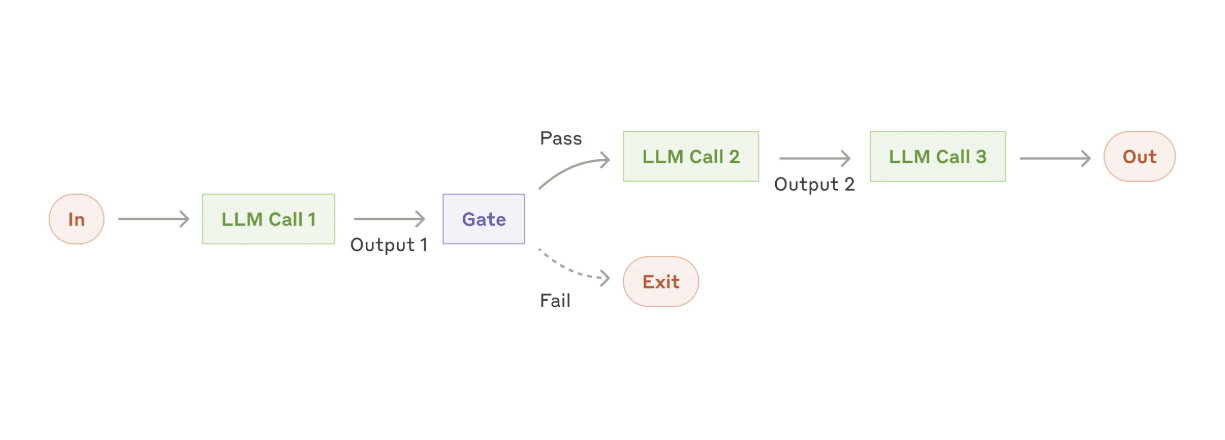

#### Example Implementation

In [6]:
from langgraph.func import entrypoint, task


# Tasks
@task
def generate_joke(topic: str):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {topic}")
    return msg.content


def check_punchline(joke: str):
    """Gate function to check if the joke has a punchline"""
    # Simple check - does the joke contain "?" or "!"
    if "?" in joke or "!" in joke:
        return "Fail"

    return "Pass"


@task
def improve_joke(joke: str):
    """Second LLM call to improve the joke"""
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {joke}")
    return msg.content


@task
def polish_joke(joke: str):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {joke}")
    return msg.content


@entrypoint()
def workflow(topic: str):
    original_joke = generate_joke(topic).result()
    if check_punchline(original_joke) == "Pass":
        return original_joke

    improved_joke = improve_joke(original_joke).result()
    return polish_joke(improved_joke).result()

In [7]:
for step in workflow.stream("cats", stream_mode="updates"):
    print(step)
    print("\n")

{'generate_joke': 'Why was the cat sitting on the computer?  \n\nBecause it wanted to keep an eye on the mouse!'}


{'improve_joke': 'Why was the cat sitting on the computer?  \n\nBecause it heard the mouse was clicking, and it wanted to paws and reflect on its next move!'}


{'polish_joke': "Why was the cat sitting on the computer? \n\nBecause it heard the mouse was clicking, and it wanted to paws and reflect on its next move! Little did it know, the mouse was actually planning a surprise party for the cat's birthday, complete with cheese-flavored cake and a laser light show!"}


{'workflow': "Why was the cat sitting on the computer? \n\nBecause it heard the mouse was clicking, and it wanted to paws and reflect on its next move! Little did it know, the mouse was actually planning a surprise party for the cat's birthday, complete with cheese-flavored cake and a laser light show!"}




## Parallelization 

With parallelization, LLMs work simultaneously on a task:

>LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

> When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

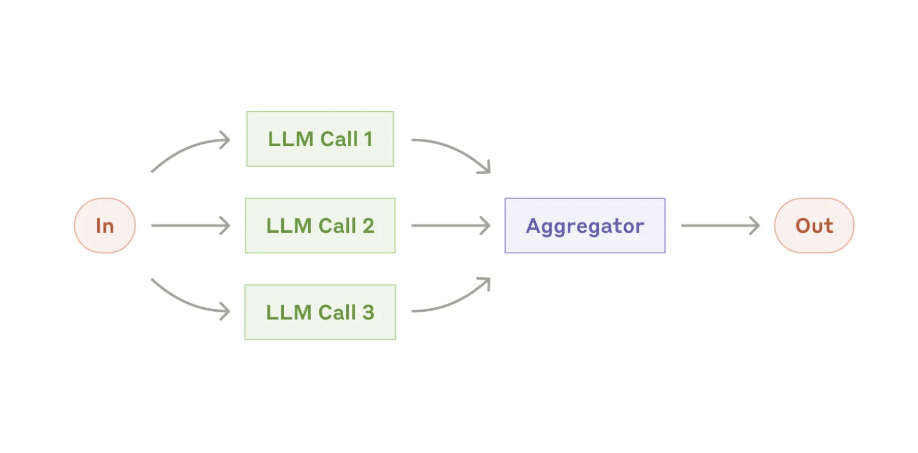

#### Example Implementation

In [8]:
@task
def call_llm_1(topic: str):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a joke about {topic}")
    return msg.content


@task
def call_llm_2(topic: str):
    """Second LLM call to generate story"""
    msg = llm.invoke(f"Write a story about {topic}")
    return msg.content


@task
def call_llm_3(topic):
    """Third LLM call to generate poem"""
    msg = llm.invoke(f"Write a poem about {topic}")
    return msg.content


@task
def aggregator(topic, joke, story, poem):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {topic}!\n\n"
    combined += f"STORY:\n{story}\n\n"
    combined += f"JOKE:\n{joke}\n\n"
    combined += f"POEM:\n{poem}"
    return combined


# Build workflow
@entrypoint()
def parallel_workflow(topic: str):
    joke_fut = call_llm_1(topic)
    story_fut = call_llm_2(topic)
    poem_fut = call_llm_3(topic)
    return aggregator(
        topic, joke_fut.result(), story_fut.result(), poem_fut.result()
    ).result()

In [9]:
for step in parallel_workflow.stream("cats", stream_mode="updates"):
    print(step)
    print("\n")

{'call_llm_1': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!'}


{'call_llm_3': "In a sunbeam's gentle grace they lie,  \nWhiskers twitch as dreams drift by.  \nSoft paws tread on twilight's seam,  \nGuardians of the night's serene.\n\nEmerald eyes, a knowing gleam,  \nIn shadows dance, a silent theme.  \nMysteries held in their midnight fur,  \nSilent whispers, no footfall's stir.\n\nCurled upon a windowsill,  \nWatching worlds in silence still.  \nA regal nod, a subtle purr,  \nThe universe contained in fur.\n\nIn moonlit gardens, they softly prowl,  \nBeneath the stars, they yawn and howl.  \nYet by the fire, they rest and play,  \nTurning night into day.\n\nOh, feline friends, with softest tread,  \nRulers of kingdoms in our head.  \nIn your gaze, a world unfurls—  \nTimeless tales of cats and curls."}


{'call_llm_2': 'Once upon a time in the quaint village of Whiskerfield, nestled between rolling hills and lush meadows, there was a pe

## Routing 

Routing classifies an input and directs it to a specialized followup task:

> Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

> When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

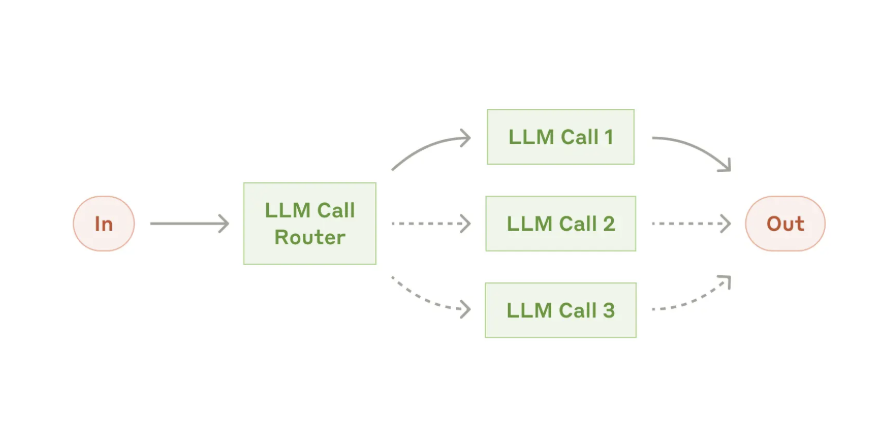

#### Example Implementation

In [10]:
from typing_extensions import Literal
from pydantic import BaseModel
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


@task
def llm_call_1(input_: str):
    """Write a story"""
    result = llm.invoke(input_)
    return result.content


@task
def llm_call_2(input_: str):
    """Write a joke"""
    result = llm.invoke(input_)
    return result.content


@task
def llm_call_3(input_: str):
    """Write a poem"""
    result = llm.invoke(input_)
    return result.content


def llm_call_router(input_: str):
    """Route the input to the appropriate node"""
    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=input_),
        ]
    )
    return decision.step


# Create workflow
@entrypoint()
def router_workflow(input_: str):
    next_step = llm_call_router(input_)
    if next_step == "story":
        llm_call = llm_call_1
    elif next_step == "joke":
        llm_call = llm_call_2
    elif next_step == "poem":
        llm_call = llm_call_3

    return llm_call(input_).result()

In [11]:
for step in router_workflow.stream("Write me a joke about cats", stream_mode="updates"):
    print(step)
    print("\n")

{'llm_call_2': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!'}


{'router_workflow': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!'}




## Orchestrator-Worker 

With orchestrator-worker, an orchestrator breaks down a task and delegates each sub-task to workers: 

> In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

> When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

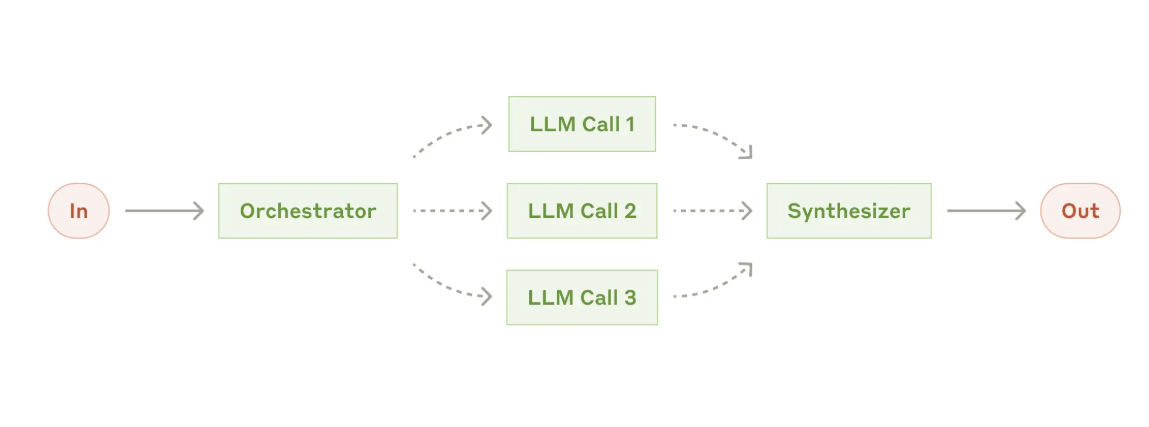

    
#### Example Implementation

In [12]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)


@task
def orchestrator(topic: str):
    """Orchestrator that generates a plan for the report"""
    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {topic}"),
        ]
    )

    return report_sections.sections


@task
def llm_call(section: Section):
    """Worker writes a section of the report"""

    # Generate section
    result = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {section.name} and description: {section.description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return result.content


@task
def synthesizer(completed_sections: list[str]):
    """Synthesize full report from sections"""
    final_report = "\n\n---\n\n".join(completed_sections)
    return final_report


@entrypoint()
def orchestrator_worker(topic: str):
    sections = orchestrator(topic).result()
    section_futures = [llm_call(section) for section in sections]
    final_report = synthesizer(
        [section_fut.result() for section_fut in section_futures]
    ).result()
    return final_report

In [13]:
for step in orchestrator_worker.stream(
    "Create a report on LLM scaling laws", stream_mode="updates"
):
    for key, value in step.items():
        print(f"Executing task '{key}'")

        if key == "orchestrator_worker":
            report = value

Executing task 'orchestrator'
Executing task 'llm_call'
Executing task 'llm_call'
Executing task 'llm_call'
Executing task 'llm_call'
Executing task 'llm_call'
Executing task 'llm_call'
Executing task 'llm_call'
Executing task 'synthesizer'
Executing task 'orchestrator_worker'


In [14]:
from IPython.display import Markdown

In [ ]:
Markdown(report)

## Evaluator-optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop: 

> In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

> When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

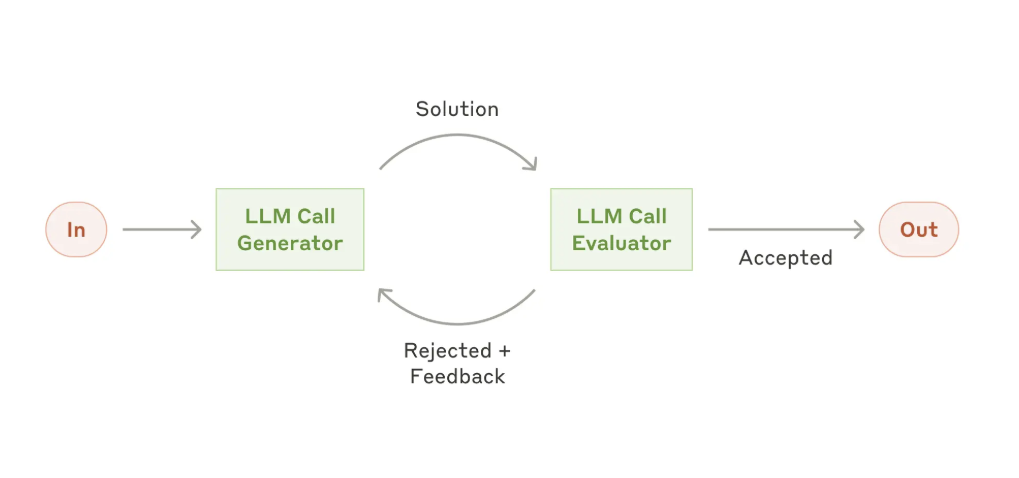

#### Example Implementation

In [16]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
@task
def llm_call_generator(topic: str, feedback: Feedback):
    """LLM generates a joke"""
    if feedback:
        msg = llm.invoke(
            f"Write a joke about {topic} but take into account the feedback: {feedback}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {topic}")
    return msg.content


@task
def llm_call_evaluator(joke: str):
    """LLM evaluates the joke"""
    feedback = evaluator.invoke(f"Grade the joke {joke}")
    return feedback


@entrypoint()
def optimizer_workflow(topic: str):
    feedback = None
    while True:
        joke = llm_call_generator(topic, feedback).result()
        feedback = llm_call_evaluator(joke).result()
        if feedback.grade == "funny":
            break

    return joke

In [17]:
for step in optimizer_workflow.stream("Cats", stream_mode="updates"):
    print(step)
    print("\n")

{'llm_call_generator': 'Why was the cat sitting on the computer?  \nBecause it wanted to keep an eye on the mouse!'}


{'llm_call_evaluator': Feedback(grade='funny', feedback="The joke is funny because it plays on the double meaning of 'mouse,' referring both to the computer accessory and the animal that cats are known to chase. It's a clever use of wordplay.")}


{'optimizer_workflow': 'Why was the cat sitting on the computer?  \nBecause it wanted to keep an eye on the mouse!'}




## Agent 

Agents are typically implemented as an LLM performing actions (via tool-calling) based on environmental feedback in a loop:

> Agents can handle sophisticated tasks, but their implementation is often straightforward. They are typically just LLMs using tools based on environmental feedback in a loop. It is therefore crucial to design toolsets and their documentation clearly and thoughtfully.

> When to use agents: Agents can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. Agents' autonomy makes them ideal for scaling tasks in trusted environments.

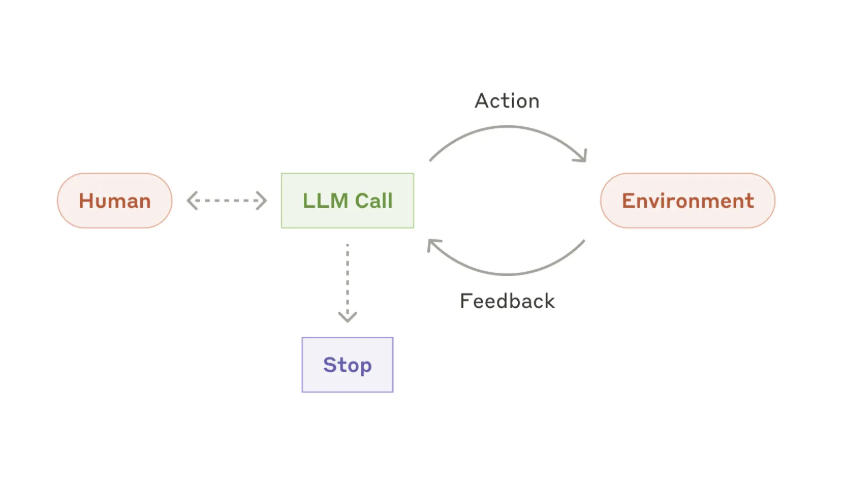

#### Example Implementation

In [18]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [19]:
from langgraph.graph import add_messages
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    ToolMessage,
    BaseMessage,
    ToolCall,
)


@task
def call_llm(messages: list[BaseMessage]):
    """LLM decides whether to call a tool or not"""
    return llm_with_tools.invoke(
        [
            SystemMessage(
                content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
            )
        ]
        + messages
    )


@task
def call_tool(tool_call: ToolCall):
    """Performs the tool call"""
    tool = tools_by_name[tool_call["name"]]
    return tool.invoke(tool_call)


@entrypoint()
def agent(messages: list[BaseMessage]):
    llm_response = call_llm(messages).result()

    while True:
        if not llm_response.tool_calls:
            break

        # Execute tools
        tool_result_futures = [
            call_tool(tool_call) for tool_call in llm_response.tool_calls
        ]
        tool_results = [fut.result() for fut in tool_result_futures]
        messages = add_messages(messages, [llm_response, *tool_results])
        llm_response = call_llm(messages).result()

    messages = add_messages(messages, llm_response)
    return messages

In [20]:
messages = [HumanMessage(content="Add 3 and 4.")]
for chunk in agent.stream(messages, stream_mode="updates"):
    print(chunk)
    print("\n")

{'call_llm': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VkBoN2yGwj3CLUTxO8K9pTJV', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 150, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-eb095581-6f92-48e4-bd07-a2e6f6a3851d-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_VkBoN2yGwj3CLUTxO8K9pTJV', 'type': 'tool_call'}], usage_metadata={'input_tokens': 150, 'output_tokens': 18, 'total_tokens': 168, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}


{'c

---

## What LangGraph provides

By constructing each of the above in LangGraph, we get a few things: 

### Persistence: Human-in-the-Loop

LangGraph persistence layer supports interruption and approval of actions (e.g., Human In The Loop). See [Module 3 of LangChain Academy](https://github.com/langchain-ai/langchain-academy/tree/main/module-3).

### Persistence: Memory 

LangGraph persistence layer supports conversational (short-term) memory and long-term memory. See [Modules 2](https://github.com/langchain-ai/langchain-academy/tree/main/module-2) [and 5](https://github.com/langchain-ai/langchain-academy/tree/main/module-5) of LangChain Academy: 

### Streaming 

LangGraph provides several ways to stream workflow / agent outputs or intermediate state. See [Module 3 of LangChain Academy](https://github.com/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb).


### Deployment

LangGraph provides an easy on-ramp for deployment, observability, and evaluation. See [module 6](https://github.com/langchain-ai/langchain-academy/tree/main/module-6) of LangChain Academy.